### Exploration of false alarms, using Portland Fire & Rescue incidents from 2010-2016

The purpose of this notebook is to explore the trends, distrubiton, and make up of false calls as reported by the Portland Fire andn Rescue. The data explored is 7 years worth of incident data provided by Portland Fire and Rescue. Data dictionary here: https://github.com/hackoregon/emergency-response/wiki/Data-Dictionary

In [203]:
import geopandas as gpd
import os 
from dotenv import load_dotenv, find_dotenv
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import geopandas as gpd
%matplotlib inline

In [16]:
# walk root diretory to find and load .env file w/ AWS host, username and password
load_dotenv(find_dotenv())

True

#### Establish connection and ability to query to Fire DB

In [17]:
# connect to postgres
def pgconnect():
    try:
        conn = psycopg2.connect(database=os.environ.get("database"), user=os.environ.get("user"), 
                            password = os.environ.get("password"), 
                            host=os.environ.get("host"), port=os.environ.get("port"))
        print("Opened database successfully")
        return conn
    
    except psycopg2.Error as e:
        print("I am unable to connect to the database")
        print(e)
        print(e.pgcode)
        print(e.pgerror)
        print(traceback.format_exc())
        return None

In [18]:
#function to to query a table from postgres and create df.
def pquery(QUERY):
    '''
    takes SQL query string, opens a cursor, and executes query in psql
    '''
    conn = pgconnect()
    cur = conn.cursor()
    
    try:
        print("SQL QUERY = "+QUERY)
        cur.execute("SET statement_timeout = 0")
        cur.execute(QUERY)
        # Extract the column names and insert them in header
        col_names = []
        for elt in cur.description:
            col_names.append(elt[0])    
    
        D = cur.fetchall() #convert query result to list
        # Create the dataframe, passing in the list of col_names extracted from the description
        return pd.DataFrame(D, columns=col_names)
        
        
    except Exception as e:
        print(e.pgerror)
            
    finally:
        conn.close()

In [19]:
#function to to query a table with geometry from postrgres and convert to df.
from geopandas import GeoSeries, GeoDataFrame

def gpd_query(QUERY):
    '''
    takes SQL query string, connects to postgres, and creates geopandas dataframe
    '''
    conn = pgconnect()
    cur = conn.cursor()
    
    try:
        print("SQL QUERY = "+QUERY+'\r\n')
        geo_df = GeoDataFrame.from_postgis(QUERY, 
        conn, geom_col='geom', crs={'init': u'epsg:4326'}, 
        coerce_float=False)
        
        print("created geopandas dataframe")
        return geo_df
        
    except Exception as e:
        print(e.pgerror)
            
    finally:
        conn.close()

In [20]:
#Query the area weighted proportion table for Census Blocks to FMA's. 

#QUERY1='''SELECT *
#FROM fmac_proportion;
#'''
#df1 = pquery(QUERY1)

In [21]:
QUERY2='''SELECT f.fma,
  CAST(round(sum(c.estimate_total*f.overlap_cbg)) AS INTEGER) AS fma_population_total, s.geom
FROM fmac_proportion f 
INNER JOIN census_total_population c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY fma_population_total DESC
'''

df2 = gpd_query(QUERY2)

Opened database successfully
SQL QUERY = SELECT f.fma,
  CAST(round(sum(c.estimate_total*f.overlap_cbg)) AS INTEGER) AS fma_population_total, s.geom
FROM fmac_proportion f 
INNER JOIN census_total_population c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY fma_population_total DESC


created geopandas dataframe


#### query tabular data
Join incidents table to incsitfound, incsitfoundsub, and typenaturecode


In [ ]:
QUERY4='''SELECT incident.incident_id,incident.fireblock, incident.incdate, incsitfoundclass.incsitfoundclass_id, incsitfoundclass.description as incDescription, typenaturecode.description as typeDescription
FROM incident
  INNER JOIN incsitfound
    ON incident.incsitfoundprm_id = incsitfound.incsitfound_id
  LEFT JOIN incsitfoundsub
    ON incsitfound.incsitfoundsub_id = incsitfoundsub.incsitfoundsub_id
  LEFT JOIN incsitfoundclass
    ON incsitfoundsub.incsitfoundclass_id = incsitfoundclass.incsitfoundclass_id
   LEFT JOIN typenaturecode
   ON incident.typenaturecode_id = typenaturecode.typenaturecode_id;
'''
df4 = pquery(QUERY4)

In [235]:
#Convert date column to actual date. Calc a year and month column from the date column. 
df4['incdate'] = pd.to_datetime(df4['incdate'])
df4['year'] = pd.DatetimeIndex(df4['incdate']).year
df4['month'] = pd.DatetimeIndex(df4['incdate']).month
df4['month_year'] = df4['incdate'].apply(lambda x: x.strftime('%B-%Y'))  
#pd.DataFrame(df4, columns=['incdate'], dtype=datetime64)
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512281 entries, 0 to 512280
Data columns (total 9 columns):
incident_id            512281 non-null int64
fireblock              512186 non-null object
incdate                512281 non-null datetime64[ns]
incsitfoundclass_id    512281 non-null int64
incdescription         512281 non-null object
typedescription        512278 non-null object
year                   512281 non-null int32
month                  512281 non-null int32
month_year             512281 non-null object
dtypes: datetime64[ns](1), int32(2), int64(2), object(4)
memory usage: 31.3+ MB


In [236]:
df4.head()

incident_id fireblock    incdate  incsitfoundclass_id  \
0       771162      0948 2010-04-07                    3   
1       771163      2860 2010-04-07                    3   
2       771164      0375 2010-04-07                    4   
3       771165      1709 2010-04-07                    3   
4       771166      1112 2010-04-07                    3   

               incdescription       typedescription  year  month  month_year  
0  MEDICAL AID / RESCUE CALLS         SICK/1ST RESP  2010      4  April-2010  
1  MEDICAL AID / RESCUE CALLS      SEIZURE/1ST RESP  2010      4  April-2010  
2        HAZARDOUS CONDITIONS  TRAFFIC ACC/1ST RESP  2010      4  April-2010  
3  MEDICAL AID / RESCUE CALLS         SICK/1ST RESP  2010      4  April-2010  
4  MEDICAL AID / RESCUE CALLS     OVERDOSE/1ST RESP  2010      4  April-2010

In [248]:
#False calls make up around 7% of the total calls from 2010-2016
df4.groupby('incdescription')['incdescription'].count().sort_values(ascending = 0)

incdescription
MEDICAL AID / RESCUE CALLS                    368084
SERVICE CALL                                   50997
FALSE CALLS                                    39210
GOOD INTENT CALLS                              24884
FIRE/EXPLOSION                                 16232
HAZARDOUS CONDITIONS                           10564
OTHER SITUATION FOUND                           1478
OVER PRESSURE RUPTURE, EXPLOSION, OVERHEAT       394
MUTUAL AID RESPONSE                              253
NATURAL CONDITIONS                               185
Name: incdescription, dtype: int64

In [249]:
falsecalls_df = df4[df4['incsitfoundclass_id'] == 7]
#falsecalls_df['count'] == 1

#39,210 false alarm records (out of 512,281 total)
falsecalls_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39210 entries, 13 to 512269
Data columns (total 9 columns):
incident_id            39210 non-null int64
fireblock              39204 non-null object
incdate                39210 non-null datetime64[ns]
incsitfoundclass_id    39210 non-null int64
incdescription         39210 non-null object
typedescription        39210 non-null object
year                   39210 non-null int32
month                  39210 non-null int32
month_year             39210 non-null object
dtypes: datetime64[ns](1), int32(2), int64(2), object(4)
memory usage: 2.7+ MB


In [250]:
falsecalls_df.head()

incident_id fireblock    incdate  incsitfoundclass_id incdescription  \
13       771175      0966 2010-04-07                    7    FALSE CALLS   
21       771185      2883 2010-04-07                    7    FALSE CALLS   
41       771207      1936 2010-04-07                    7    FALSE CALLS   
47       771213      1234 2010-04-07                    7    FALSE CALLS   
87       771257      1609 2010-04-07                    7    FALSE CALLS   

                typedescription  year  month  month_year  
13     AUTOMATIC FIRE ALARM-RES  2010      4  April-2010  
21    AUTOMATIC FIRE ALARM-COMM  2010      4  April-2010  
41  CHIMNEY/FIREPLACE/WOODSTOVE  2010      4  April-2010  
47    AUTOMATIC FIRE ALARM-COMM  2010      4  April-2010  
87    AUTOMATIC FIRE ALARM-COMM  2010      4  April-2010

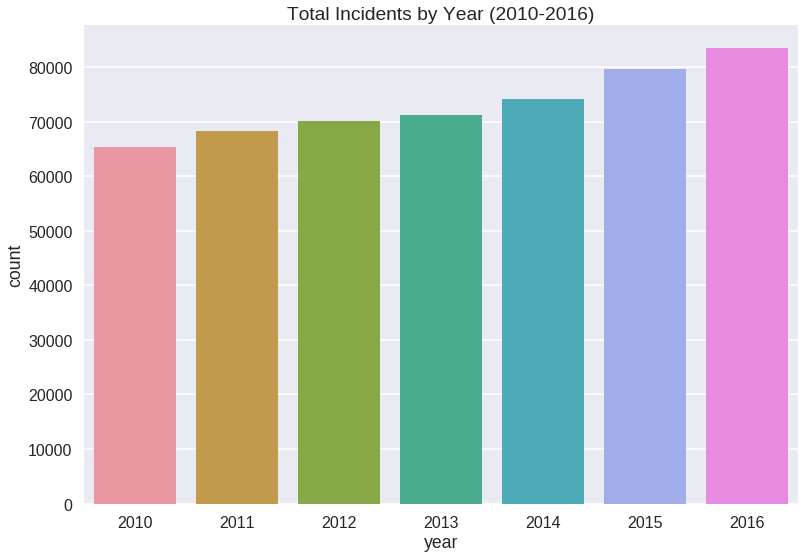

In [272]:
#total incidents over time
sns.set_style("darkgrid")
sns.set_palette('dark')
sns.set_context("poster")
sns.countplot(x='year', data = df4)
sns.plt.title('Total Incidents by Year (2010-2016)')

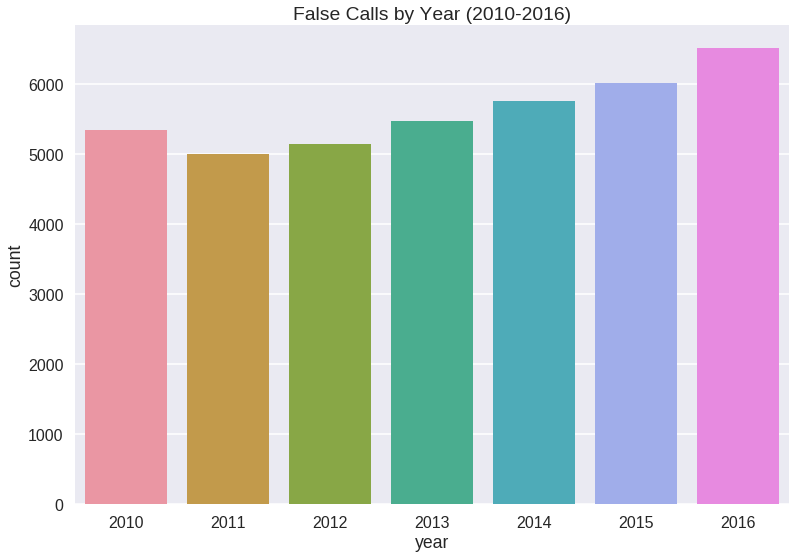

In [271]:
#False calls are rising over time. Almost in lockstep with total incidents over time (except for 2010)
sns.countplot(x='year', data = falsecalls_df)
sns.plt.title('False Calls by Year (2010-2016)')

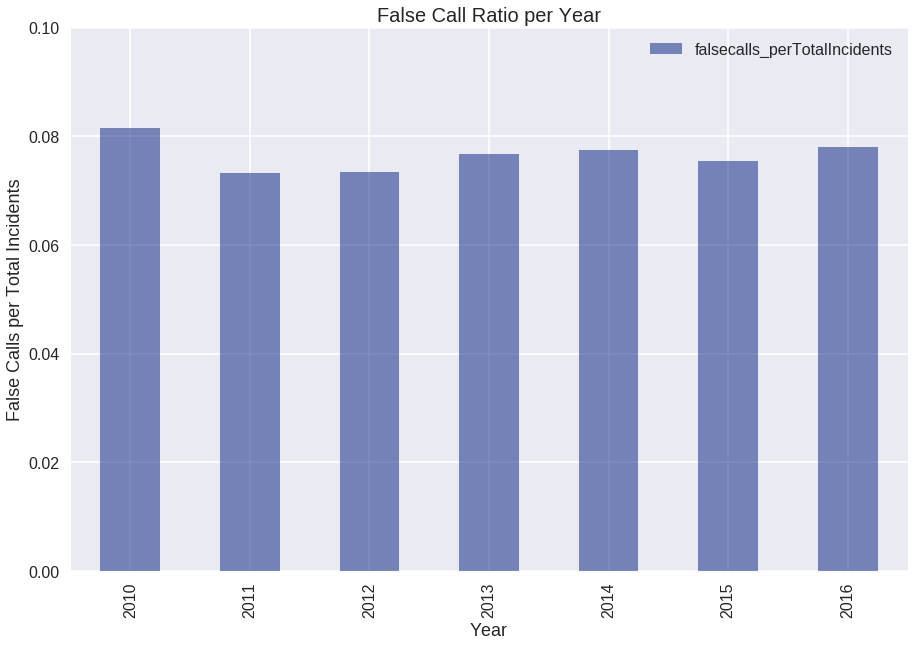

In [253]:
#Count incidents per year. Count faslse alarms per year. Join in to same data frame.  
fc_groupYear = (falsecalls_df.groupby(falsecalls_df.year)['incident_id'].count()).to_frame().reset_index()
fd_groupYear = (df4.groupby(df4.year)['incident_id'].count()).to_frame().reset_index()
fcfd_merge = pd.merge(left=fc_groupYear,right=fd_groupYear,  how='left', left_on='year', right_on='year')
fcfd_merge["falsecalls_perTotalIncidents"] = fcfd_merge["incident_id_x"] / fcfd_merge["incident_id_y"]

#plot
ax = fcfd_merge.plot(x='year', y='falsecalls_perTotalIncidents',ylim=(0,.1), kind='bar',figsize=(15, 10), alpha =.5)
ax.set_title('False Call Ratio per Year',fontsize= 20)
ax.set_xlabel("Year", fontsize=18)
ax.set_ylabel('False Calls per Total Incidents', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)

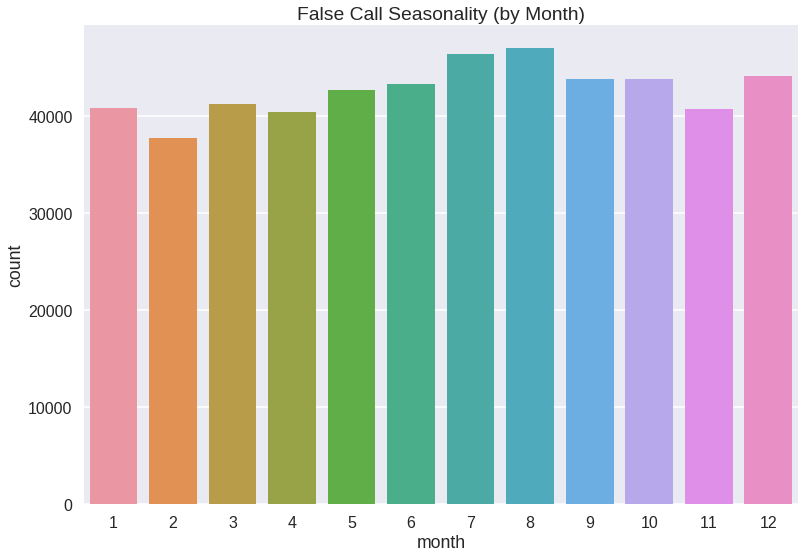

In [330]:
sns.set_style("darkgrid")
sns.set_palette('dark')
sns.set_context("poster")
#plt.figure(figsize=(10, 10))
#sns.countplot(x='incdate', data = df4, palette="Set3")
sns.countplot(x='month', data = df4)
sns.plt.title('False Call Seasonality (by Month)')


In [343]:
#Top type descriptions for false calls. Vast majority are related to automatic fire alarms 30008 out of 39210 (ie 76.6%)
sf3= falsecalls_df.groupby('typedescription')['typedescription'].count().sort_values(ascending = 0)
#sf3
falsecalls_total = sf3.to_frame(name='count')
#falsecalls_total.columns = ['count']
#falsecalls_total.reindex()
falsecalls_total[:30]

count
typedescription                      
AUTOMATIC FIRE ALARM-COMM       25007
AUTOMATIC FIRE ALARM-RES         5001
AUDIBLE FIRE ALARM               2992
UNKNOWN/FIRE ONLY                1859
CARBON MONOXIDE ALARM             719
SMOKE IN AREA- OUTSIDE            255
MISCELLANEOUS FIRE                233
ILLEGAL BURN                      203
GRASS/BARKDUST/TREE FIRE          166
SMOKE INVEST.-STRUCTURE           155
ELEVATOR RESCUE                   152
ODOR/SMELL (NO SMOKE VISIBLE)     149
VEHICLE/TRAILER FIRE              148
NATURAL GAS-ODOR/INVESTIGATION    139
UNKNOWN/1ST RESP                  120
POWER LINE/POLE DOWN/ARCING       113
PUBLIC ASSIST                     111
ASSAULT/1ST RESP                  105
OVERDOSE/1ST RESP                  96
BREATHING/1ST RESP                 95
TRAUMA/1ST RESP                    94
MUTUAL AID                         90
TRAFFIC ACC/1ST RESP               85
RESD FIRE (HOUSE OR DUPLEX)        82
UNCONSCIOUS/1ST RESP               82
SICK/1ST RESP                      64
CHEST PAIN/1ST RESP                59
COMMERCIAL FIRE                    57
DUMPSTER/GARBAGE CAN/TRASH         52
WATER PROBLEM                      52

In [344]:
#sns.set_style("white") 
#brplot =  sns.barplot(x="count", y="typedescription", data=falsecalls_total)
#title = ('Incidents sorted by Top 25 typenaturecode')
# Add title with space below for x-axix ticks and label
#brplot.set_title(title, fontsize=15, y=1.06)
#brplot.set_ylabel('Nature Code Type', fontsize=12, rotation=90) # rota
#brplot.set_xlabel('Count', fontsize=12)
# brplot.tick_params(axis='both', labelsize=10)

In [353]:
#Crosstabulate on typedescription to set up for timeseries plot. 
crosstab = pd.crosstab(falsecalls_df.incdate, falsecalls_df.typedescription)
select_df = crosstab[['AUTOMATIC FIRE ALARM-COMM', 'AUTOMATIC FIRE ALARM-RES', 'AUDIBLE FIRE ALARM', 
                      'UNKNOWN/FIRE ONLY', 'CARBON MONOXIDE ALARM', 'SMOKE IN AREA- OUTSIDE']]

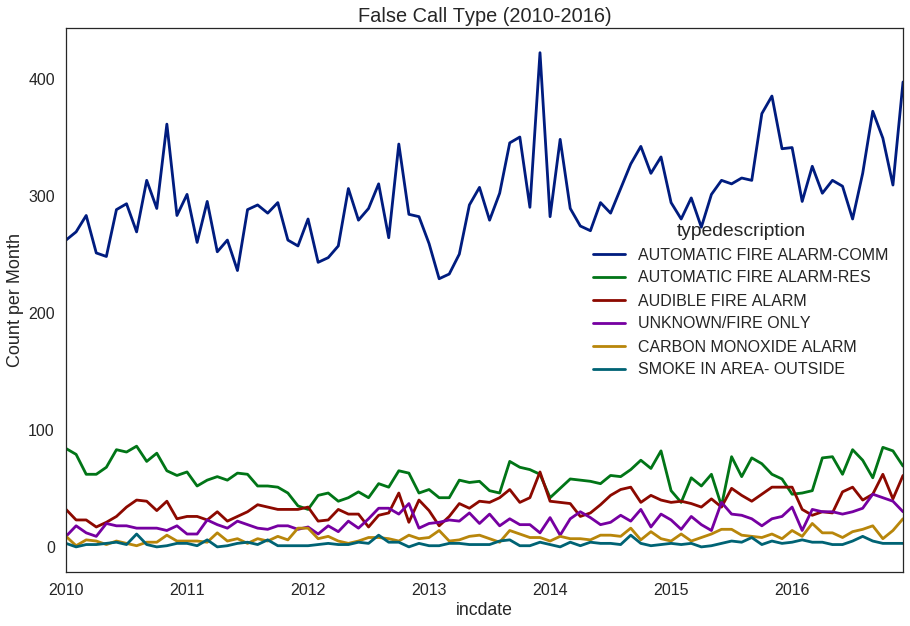

In [358]:
select_df_yearly = select_df.resample('M').sum()
#select_df.head()
ax1 = select_df_yearly.ix['01-2010':'12-2016'].plot(figsize=(15, 10))
ax1.set_title('False Call Type (2010-2016)',fontsize= 20)
ax1.set_ylabel('Count per Month', fontsize=18)
#select_df.info()

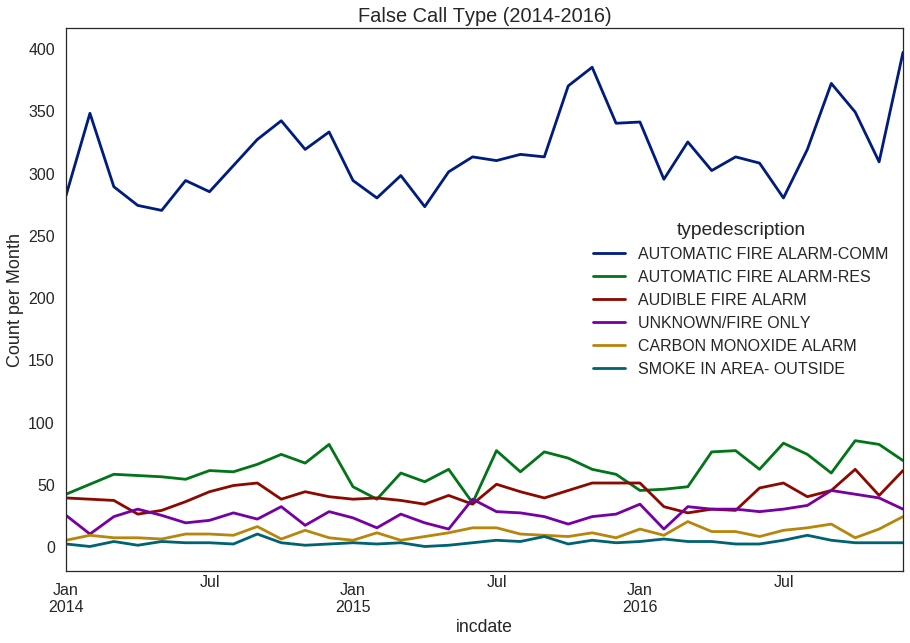

In [359]:
#df39 = falsecalls_byday_df.loc['20130102','20130104','','']

select_df_monthly = select_df.resample('M').sum()
#select_df.head()
ax2 = select_df_monthly.ix['01-2014':'12-2016'].plot(figsize=(15, 10))
ax2.set_title('False Call Type (2014-2016)',fontsize= 20)
ax2.set_ylabel('Count per Month', fontsize=18)
#select_df.info()

#### Geographic exploration (by Fire Managmenet Area and Fire Block)

Query geometry from pg instance. 

In [350]:
QUERY3='''SELECT gid, fma, resp_zone, geom
FROM fblocks;
'''

df3 = gpd_query(QUERY3)
df3 = df3.rename(columns = {'resp_zone':'fireblock'})
df3.head(15)

Opened database successfully
SQL QUERY = SELECT gid, fma, resp_zone, geom
FROM fblocks;


created geopandas dataframe


gid fma fireblock                                               geom
0     1  01      0103  (POLYGON ((-122.6739595339999 45.5319685220000...
1     2  01      0106  (POLYGON ((-122.669984655 45.52957948400007, -...
2     3  01      0109  (POLYGON ((-122.669181766 45.52755928500005, -...
3     4  01      0111  (POLYGON ((-122.666151838 45.52710833500004, -...
4     5  01      0112  (POLYGON ((-122.664736116 45.52866324200005, -...
5     6  01      0115  (POLYGON ((-122.676515463 45.52520707400004, -...
6     7  01      0118  (POLYGON ((-122.6733829249999 45.5231291860000...
7     8  01      0121  (POLYGON ((-122.667814386 45.52304640800003, -...
8     9  01      0124  (POLYGON ((-122.660706542 45.52507661900006, -...
9    10  01      0126  (POLYGON ((-122.666439872 45.52104186700006, -...
10   11  01      0127  (POLYGON ((-122.659707187 45.52293376100005, -...
11   12  01      0130  (POLYGON ((-122.677167095 45.52175154600008, -...
12   13  01      0133  (POLYGON ((-122.668259896 45.51968685400004, -...
13   14  01      0136  (POLYGON ((-122.654632466 45.52220960500006, -...
14   15  01      0139  (POLYGON ((-122.650294658 45.52413432600008, -...

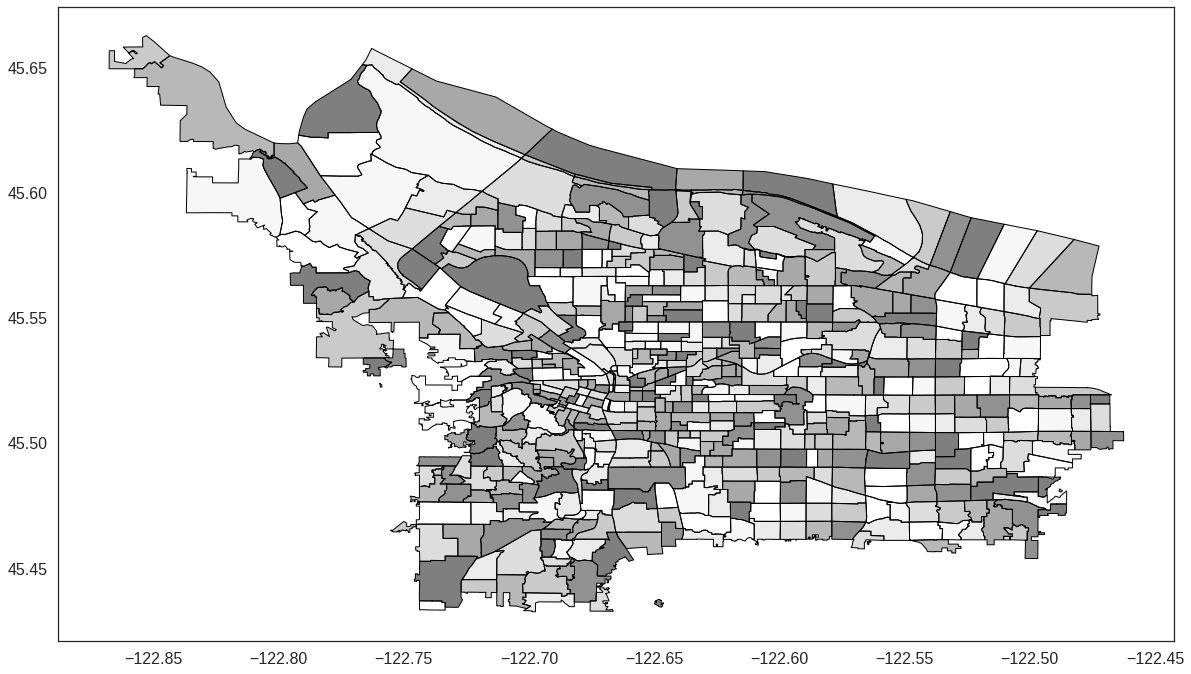

In [365]:
#Fireblocks
#df3.plot(figsize=(20,20), column='fma') 
df3.plot(figsize=(20,20))

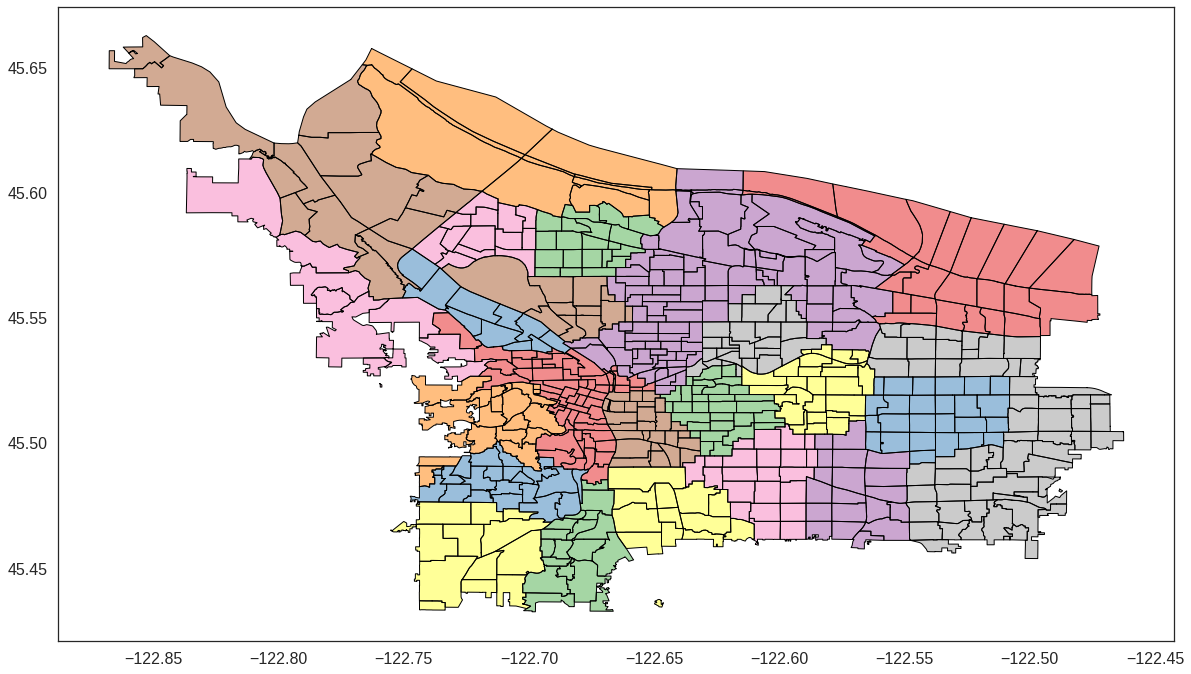

In [366]:
#Plot fire blocks and FMA's. FMA's correspond to the colors, Fireblocks to the individual geometries.
#Fireblocks are coincidental with FMA's. 
df3.plot(figsize=(20,20), column='fma')

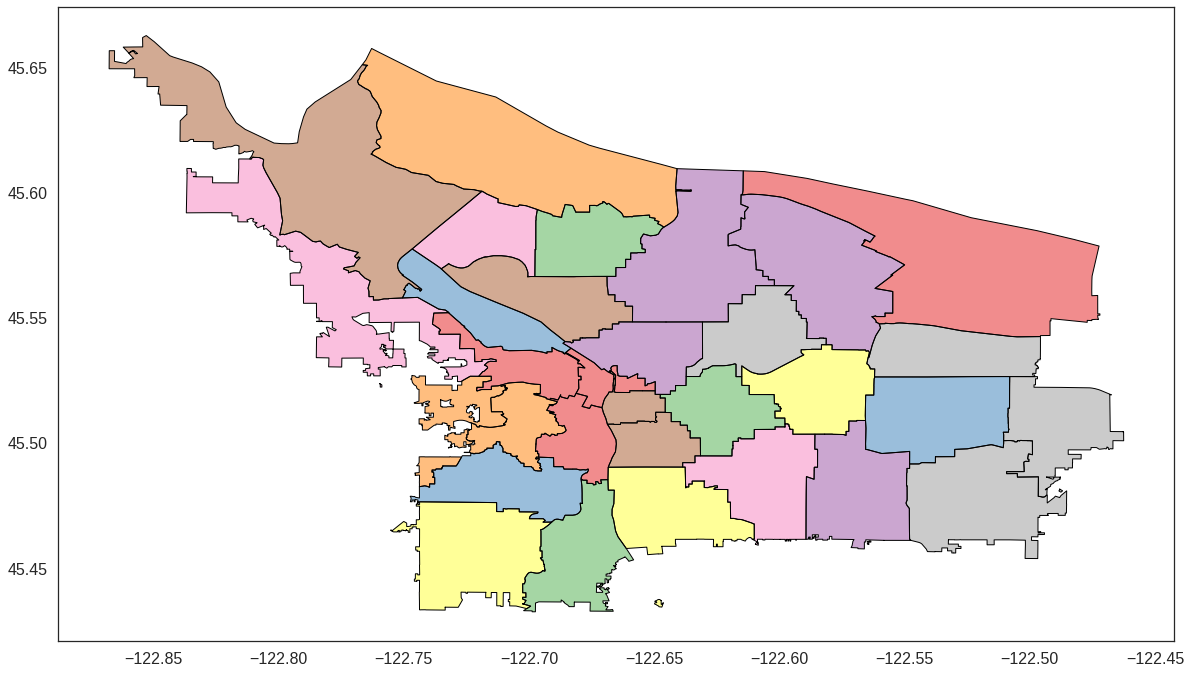

In [362]:
FMAs = df3.dissolve(by='fma').reset_index()
FMAs.plot(figsize=(20,20), column='fma') 

#### join incident counts and other fields in interest to FMAs and Fire blocks

In [370]:
falsecalls_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39210 entries, 13 to 512269
Data columns (total 9 columns):
incident_id            39210 non-null int64
fireblock              39204 non-null object
incdate                39210 non-null datetime64[ns]
incsitfoundclass_id    39210 non-null int64
incdescription         39210 non-null object
typedescription        39210 non-null object
year                   39210 non-null int32
month                  39210 non-null int32
month_year             39210 non-null object
dtypes: datetime64[ns](1), int32(2), int64(2), object(4)
memory usage: 2.7+ MB


In [385]:
#Sum count of false calls by block group
sf1 = falsecalls_df.groupby(['fireblock'])['incsitfoundclass_id'].count()
df5 = sf1.to_frame().reset_index()
df5.columns = ['fireblock', 'FalseCall_Count']
df5.head()
#what are the non-number fireblock id's?

fireblock  FalseCall_Count
0      0103              272
1      0106                5
2      0109              404
3      0111                1
4      0112               63

In [399]:
crosstab = pd.crosstab(falsecalls_df.fireblock, falsecalls_df.typedescription)
FA_Desc_fireblock_df = crosstab[['AUTOMATIC FIRE ALARM-COMM', 'AUTOMATIC FIRE ALARM-RES', 'AUDIBLE FIRE ALARM', 
                      'UNKNOWN/FIRE ONLY', 'CARBON MONOXIDE ALARM', 'SMOKE IN AREA- OUTSIDE']]

FA_Desc_fireblock_df.index.rename(name='fireblock')
#FA_Desc_fireblock_df.set_index()
FA_Desc_fireblock_df.reset_index(drop=True)
FA_Desc_fireblock_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 716 entries, 0103 to XP
Data columns (total 6 columns):
AUTOMATIC FIRE ALARM-COMM    716 non-null int64
AUTOMATIC FIRE ALARM-RES     716 non-null int64
AUDIBLE FIRE ALARM           716 non-null int64
UNKNOWN/FIRE ONLY            716 non-null int64
CARBON MONOXIDE ALARM        716 non-null int64
SMOKE IN AREA- OUTSIDE       716 non-null int64
dtypes: int64(6)
memory usage: 39.2+ KB


In [400]:
df3.reset_index()
df5.reset_index()
dt6 = pd.merge(left=df3,right=df5,  how='left', left_on='fireblock', right_on='fireblock', suffixes=('_left', '_right'))
dt7 = pd.merge(left=df6,right=FA_Desc_fireblock_df,  how='left', left_on='fireblock', right_on='fireblock', suffixes=('_left', '_right'))
dt6.head()

KeyError: 'fireblock'

In [75]:
#pd.merge(df3, df5, on='fireblock', how='inner')


In [348]:
dt6.head(20)

NameError: name 'dt6' is not defined

In [360]:
#Plot False Calls per Fire Block (total over 5 year)
dt6.plot(figsize=(35,35), column='FalseCall_Count', cmap='OrRd')

NameError: name 'dt6' is not defined